# Graduate Project of BP Regression version 7.0 - Final Version

## Initialize machine learning library

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as opt
import matplotlib.pyplot as plt
from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
plt.close('all')
print(torch.__version__)

2.6.0+cpu


### Set computing device as CPU

In [2]:
device = torch.device("cpu")
print(f"Using Device: {device}")

Using Device: cpu


## Data load in and pre-processing

In [3]:
res_df = pd.read_csv("../data/data_bp.csv", header=0)
# features = features.transpose()
# features = data.values.T.astype(np.float32)
trans_df = pd.read_csv("../data/data_trans.csv", header=0)
trans = trans_df.iloc[:, :5]
res = res_df.iloc[:, :5]

Check data shape

In [4]:
print("data dimension:", res.shape)
print("data dimension:", trans.shape)

data dimension: (792, 5)
data dimension: (324, 5)


### Draw original feature-describing histograms

In [5]:
lab = pd.DataFrame({
    'Al thickness': res.iloc[:, 0],
    'LN thickness': res.iloc[:, 1],
    'SAW half-wavelength': res.iloc[:, 2],
})

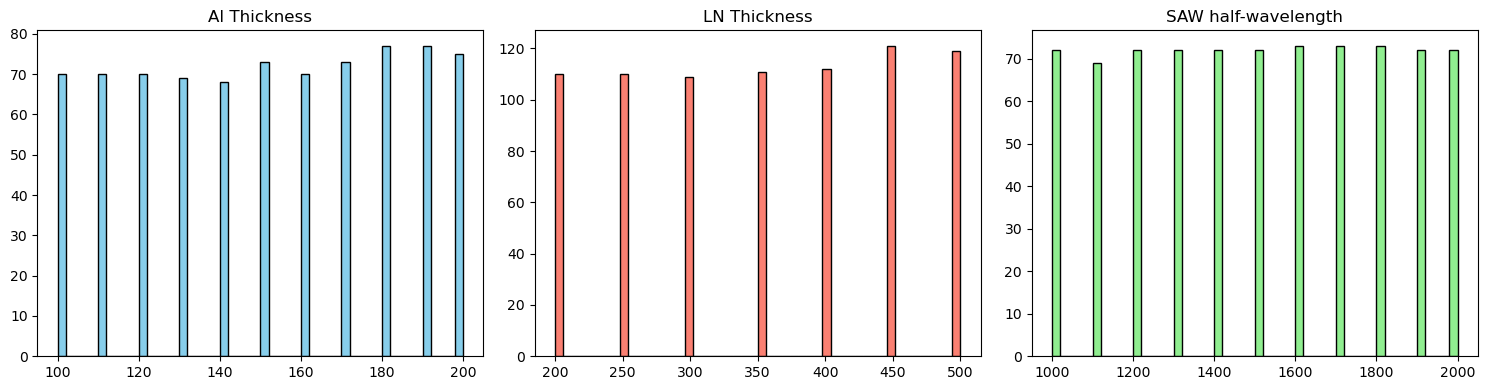

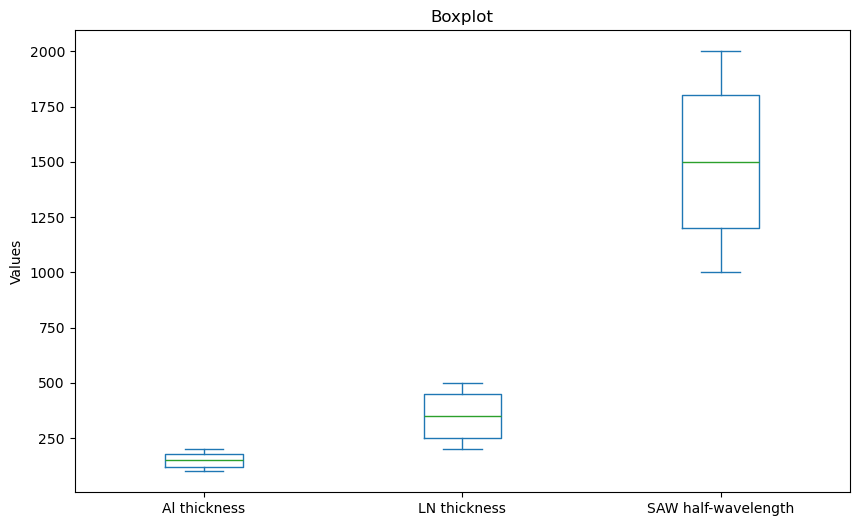

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(lab['Al thickness'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Al Thickness')

axes[1].hist(lab['LN thickness'], bins=50, color='salmon', edgecolor='black')
axes[1].set_title('LN Thickness')

axes[2].hist(lab['SAW half-wavelength'], bins=50, color='lightgreen', edgecolor='black')
axes[2].set_title('SAW half-wavelength')

# 自动调整子图间距
plt.tight_layout()
plt.show()
lab.describe()

lab.plot(kind='box', figsize=(10, 6))
plt.title("Boxplot")
plt.ylabel("Values")
plt.show()

### Set label and transform it into a nparray

In [7]:
labels = np.array(res.iloc[:,4:])
features = np.array(res.iloc[:, :4])
new_labels = np.array(trans.iloc[:,3:])
new_features = np.array(trans.iloc[:, :3])
lab.describe()

,Al thickness,LN thickness,SAW half-wavelength
count,792.000000,792.000000,792.000000
mean,151.060606,353.282828,1502.272727
std,31.796387,100.607916,315.739473
min,100.000000,200.000000,1000.000000
25%,120.000000,250.000000,1200.000000
50%,150.000000,350.000000,1500.000000
75%,180.000000,450.000000,1800.000000
max,200.000000,500.000000,2000.000000


## Exploratory Data Analysis

### Show the variation of respective features

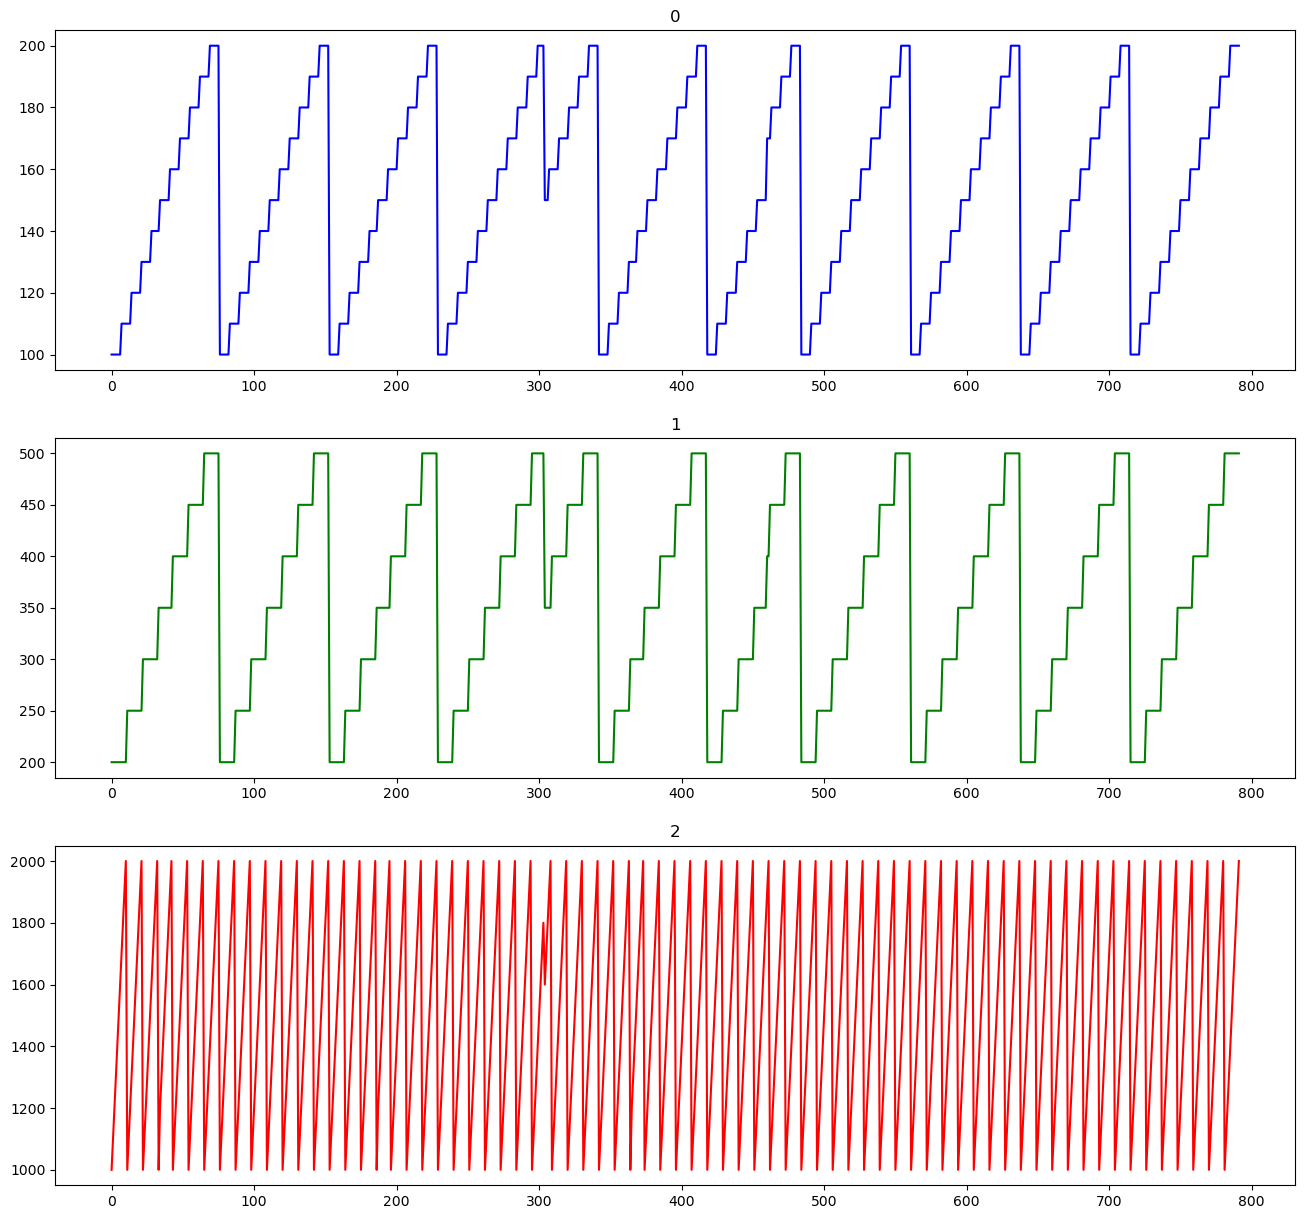

In [8]:
plt.figure(figsize=(16,15))
color = ['b', 'g', 'r']
for i in range(3):
  plt.subplot(3,1, i+1)
  a, = plt.plot(features[:,i],color= color[i])
  plt.title(i)

plt.show()

### Data standardization using sklearn

In [9]:
import seaborn as sns
import joblib
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(features, labels, train_size = 0.9, shuffle = True, random_state = 1888)
scaler_x = preprocessing.StandardScaler()
scaler_y = preprocessing.StandardScaler()
scaled_x_train = scaler_x.fit_transform(x_train)
scaled_x_val = scaler_x.transform(x_val)
scaled_y_train = scaler_y.fit_transform(y_train)
scaled_y_val = scaler_y.transform(y_val)

## Split data set into training and validating

In [10]:
M_train = x_train.shape[0] 
M_val = x_val.shape[0]  

x_train = torch.FloatTensor(scaled_x_train)
y_train = torch.FloatTensor(scaled_y_train)
x_val = torch.FloatTensor(scaled_x_val)


### Set up BPNet

In [11]:
class BPNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(BPNet, self).__init__()
        self.layers = nn.ModuleList()
        current_size = input_size
        for i, hidden_size in enumerate(hidden_sizes):
            self.layers.append(nn.Linear(current_size, hidden_size))
            self.layers.append(nn.Tanh())
            current_size = hidden_size
        self.layers.append(nn.Linear(current_size, output_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

## Constract BP Network

### Import torch libraries

In [12]:
import torch.nn as nn
from torch.nn import Conv1d 
from torch.nn import MaxPool1d 
from torch.nn import Flatten 
from torch.nn import AvgPool1d
from torch.nn import BatchNorm1d
from torch.nn import Linear 
from torch.utils.data import DataLoader, TensorDataset 
import torch.optim as optim
import torch.nn.functional as F

### Define Hyper-parameters and set dataloader

In [13]:
input_size = scaled_x_train.shape[1]
output_size = scaled_y_train.shape[1]
hidden_layer_config = [4,8,16,32,16,8,4]

model = BPNet(input_size, hidden_layer_config, output_size)
print("Model Architecture:")
print(model)

Model Architecture:
BPNet(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=16, bias=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): Tanh()
    (10): Linear(in_features=16, out_features=8, bias=True)
    (11): Tanh()
    (12): Linear(in_features=8, out_features=4, bias=True)
    (13): Tanh()
    (14): Linear(in_features=4, out_features=1, bias=True)
  )
)


### Set Training Parameters

In [14]:
epochs = 5000
learning_rate = 0.001
goal_loss = 1e-6

criterion = nn.MSELoss()  # Mean Squared Error Loss (common for regression)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer

### Training BPNet model

In [15]:
print("\nStarting Training...")
for epoch in range(epochs):
    model.train()  # Set model to training mode
    
    # Forward pass
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Compute gradients
    optimizer.step()       # Update weights
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.8f}')
    
    if loss.item() <= goal_loss:
        print(f'Goal error tolerance ({goal_loss}) reached at epoch {epoch+1}. Training stopped.')
        break
print("Training Finished.")


Starting Training...
Epoch [100/5000], Loss: 0.44159159
Epoch [200/5000], Loss: 0.31532305
Epoch [300/5000], Loss: 0.28268194
Epoch [400/5000], Loss: 0.27639401
Epoch [500/5000], Loss: 0.27343416
Epoch [600/5000], Loss: 0.27115187
Epoch [700/5000], Loss: 0.26904610
Epoch [800/5000], Loss: 0.26659817
Epoch [900/5000], Loss: 0.26269627
Epoch [1000/5000], Loss: 0.24003009
Epoch [1100/5000], Loss: 0.21498293
Epoch [1200/5000], Loss: 0.16199473
Epoch [1300/5000], Loss: 0.09017736
Epoch [1400/5000], Loss: 0.05779421
Epoch [1500/5000], Loss: 0.03220612
Epoch [1600/5000], Loss: 0.02389553
Epoch [1700/5000], Loss: 0.01929972
Epoch [1800/5000], Loss: 0.01736717
Epoch [1900/5000], Loss: 0.01494964
Epoch [2000/5000], Loss: 0.01352525
Epoch [2100/5000], Loss: 0.01235936
Epoch [2200/5000], Loss: 0.01098456
Epoch [2300/5000], Loss: 0.00999493
Epoch [2400/5000], Loss: 0.00917407
Epoch [2500/5000], Loss: 0.00854133
Epoch [2600/5000], Loss: 0.00808903
Epoch [2700/5000], Loss: 0.00748635
Epoch [2800/500

## Simulation

In [16]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for inference
    y_sim1_scaled = model(x_train)
    y_sim2_scaled = model(x_val)
    make_dot(y_sim2_scaled, params=dict(model.named_parameters())).render("net_graph", format="png")

In [17]:
# %% Data Denormalization
# Convert PyTorch tensors to NumPy arrays for scalers
y_sim1_scaled_np = y_sim1_scaled.numpy()
y_sim2_scaled_np = y_sim2_scaled.numpy()

num_output_features_to_evaluate = scaled_y_train.shape[1]

### Compare predictions to actural values


**************************************************
           Metrics for Output Feature 1           
**************************************************


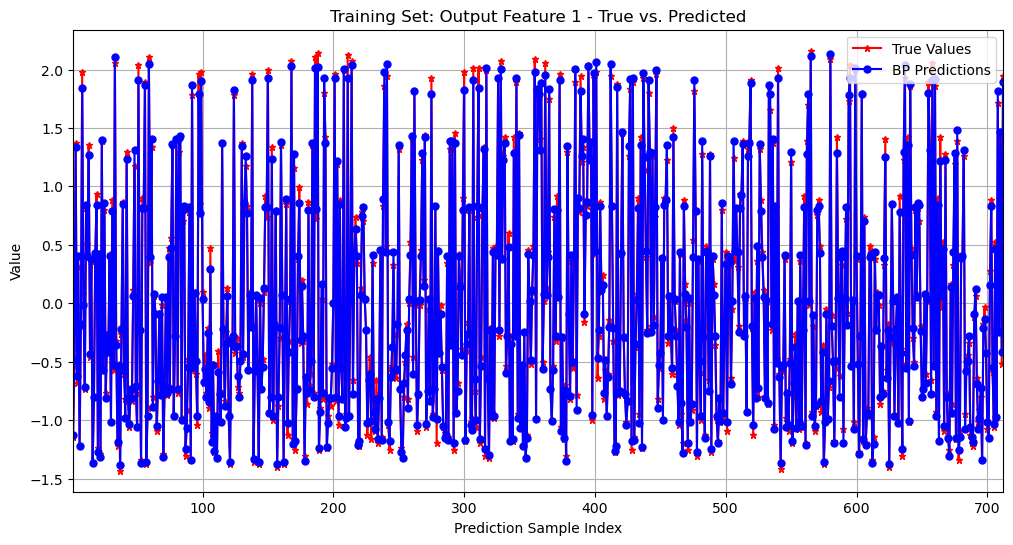

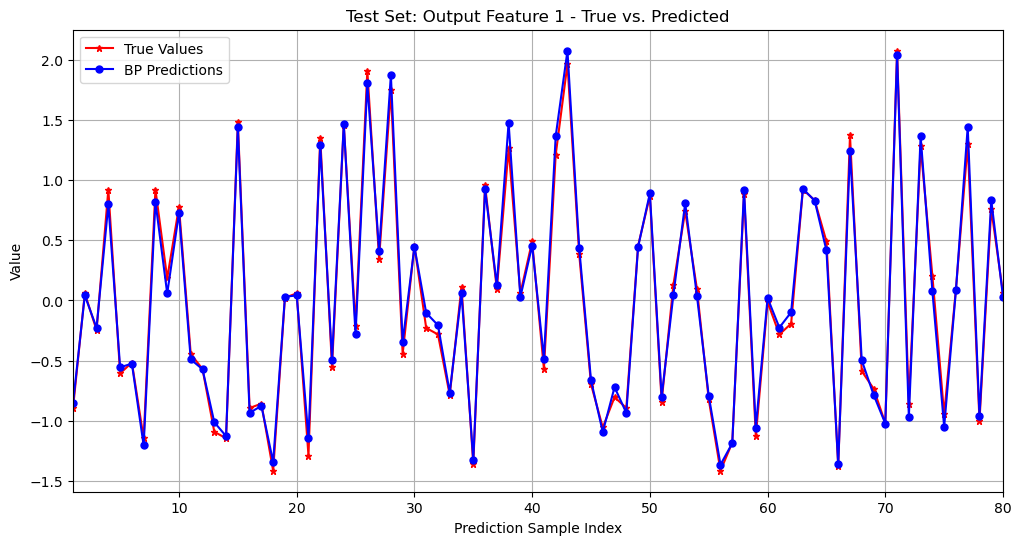

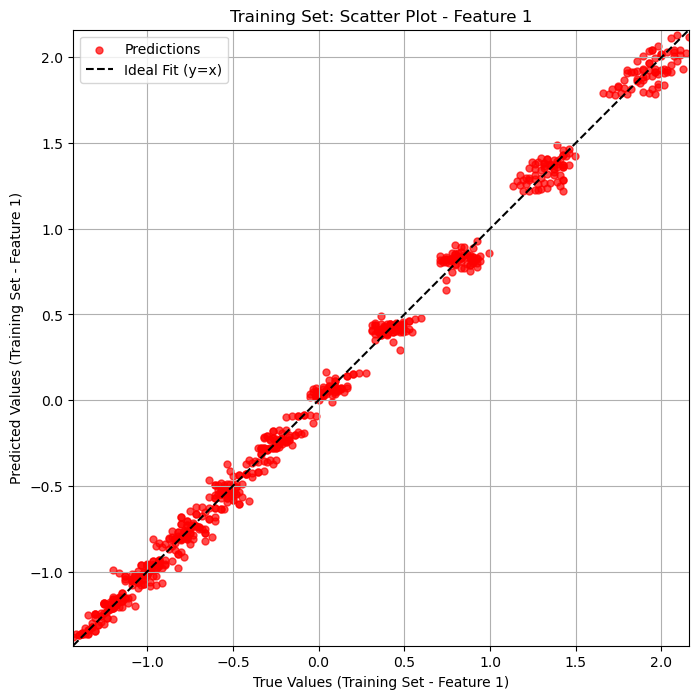

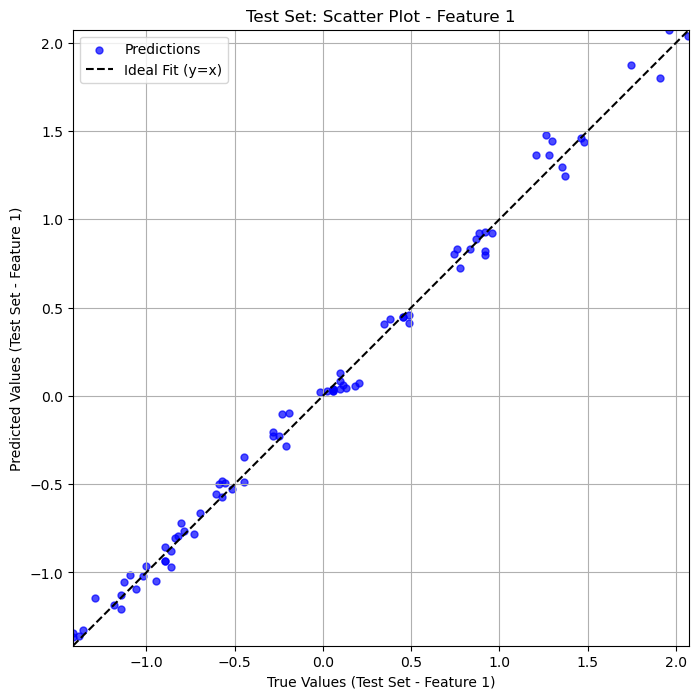

Training Set R2: 0.9958
Test Set     R2: 0.9938
Training Set MSE: 0.0042
Test Set     MSE: 0.0053


In [18]:
for i in range(num_output_features_to_evaluate):
    print(f"\n**************************************************")
    print(f"           Metrics for Output Feature {i+1}           ")
    print(f"**************************************************")

    # Extract current feature's true values and predictions
    T_train_feat_true = scaled_y_train[:, i]
    T_sim1_feat_pred = y_sim1_scaled_np[:, i]
    T_test_feat_true = scaled_y_val[:, i]
    T_sim2_feat_pred = y_sim2_scaled_np[:, i]
    

    # %% Plotting: Line plot of True vs. Predicted values
    # Training set
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(1, M_train + 1), T_train_feat_true, 'r-*', label='True Values', markersize=5)
    plt.plot(np.arange(1, M_train + 1), T_sim1_feat_pred, 'b-o', label='BP Predictions', markersize=5)
    plt.legend()
    plt.xlabel('Prediction Sample Index')
    plt.ylabel('Value')
    plt.title(f'Training Set: Output Feature {i+1} - True vs. Predicted')
    plt.xlim([1, M_train])
    plt.grid(True)
    plt.show()

    # Test set
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(1, M_val + 1), T_test_feat_true, 'r-*', label='True Values', markersize=5)
    plt.plot(np.arange(1, M_val + 1), T_sim2_feat_pred, 'b-o', label='BP Predictions', markersize=5)
    plt.legend()
    plt.xlabel('Prediction Sample Index')
    plt.ylabel('Value')
    plt.title(f'Test Set: Output Feature {i+1} - True vs. Predicted')
    plt.xlim([1, M_val])
    plt.grid(True)
    plt.gcf().set_facecolor('w') # Set figure background to white
    plt.show()

    # %% Plotting: Scatter plot of True vs. Predicted values
    # Training set
    plt.figure(figsize=(8, 8))
    min_val_train = min(np.min(T_train_feat_true), np.min(T_sim1_feat_pred))
    max_val_train = max(np.max(T_train_feat_true), np.max(T_sim1_feat_pred))
    plt.scatter(T_train_feat_true, T_sim1_feat_pred, s=25, c='red', alpha=0.7, label='Predictions')
    plt.plot([min_val_train, max_val_train], [min_val_train, max_val_train], '--k', label='Ideal Fit (y=x)')
    plt.xlabel(f'True Values (Training Set - Feature {i+1})')
    plt.ylabel(f'Predicted Values (Training Set - Feature {i+1})')
    plt.title(f'Training Set: Scatter Plot - Feature {i+1}')
    plt.xlim([min_val_train, max_val_train])
    plt.ylim([min_val_train, max_val_train])
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    # Test set
    plt.figure(figsize=(8, 8))
    min_val_test = min(np.min(T_test_feat_true), np.min(T_sim2_feat_pred))
    max_val_test = max(np.max(T_test_feat_true), np.max(T_sim2_feat_pred))
    plt.scatter(T_test_feat_true, T_sim2_feat_pred, s=25, c='blue', alpha=0.7, label='Predictions')
    plt.plot([min_val_test, max_val_test], [min_val_test, max_val_test], '--k', label='Ideal Fit (y=x)')
    plt.xlabel(f'True Values (Test Set - Feature {i+1})')
    plt.ylabel(f'Predicted Values (Test Set - Feature {i+1})')
    plt.title(f'Test Set: Scatter Plot - Feature {i+1}')
    plt.xlim([min_val_test, max_val_test])
    plt.ylim([min_val_test, max_val_test])
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    
    # %% Other Relevant Metrics
    # R-squared (Coefficient of Determination)
    r2_train = r2_score(T_train_feat_true, T_sim1_feat_pred)
    r2_test = r2_score(T_test_feat_true, T_sim2_feat_pred)
    print(f"Training Set R2: {r2_train:.4f}")
    print(f"Test Set     R2: {r2_test:.4f}")
    
    # Mean Squared Error (MSE)
    mse_train = mean_squared_error(T_train_feat_true, T_sim1_feat_pred)
    mse_test = mean_squared_error(T_test_feat_true, T_sim2_feat_pred)
    print(f"Training Set MSE: {mse_train:.4f}")
    print(f"Test Set     MSE: {mse_test:.4f}")

In [19]:
# 冻结所有参数
for param in model.parameters():
    param.requires_grad = False

original_last_layer_in_features = model.layers[-1].in_features
new_output_size = y_new_train.shape[1]

device = torch.device("cpu")
model.to(device)

model.layers = model.layers[:-2]  # 删除倒数两个层：Tanh + Linear
model.layers.append(nn.Linear(4, 2).to(device))  # 直接加入新线性层

for param in model.layers[-1].parameters():
    param.requires_grad = True

print("模型结构修改完毕，除最后一层外均已冻结。")
print("新的最后一层结构:", model.layers[-1])

optimizer_ft = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

模型结构修改完毕，除最后一层外均已冻结。
新的最后一层结构: Linear(in_features=4, out_features=2, bias=True)


In [20]:
num_samples = 250
ft_epochs = 5000 # 为微调设置的epochs，可以根据情况调整
ft_goal_loss = 1e-5 # 微调的早期停止目标

print("\n开始迁移学习训练...")

print(f"\n--- 使用 {num_samples/5} 个新样本进行训练 ---")

indices = np.random.choice(scaled_x_new_train.shape[0], num_samples, replace=False)
current_x_train = torch.FloatTensor(scaled_x_new_train[indices]).to(device)
current_y_train = torch.FloatTensor(scaled_y_new_train[indices]).to(device)

model.train()
for epoch in range(ft_epochs):
    optimizer_ft.zero_grad()
    outputs = model(current_x_train)
    loss = criterion_ft(outputs, current_y_train)
    loss.backward()
    optimizer_ft.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{ft_epochs}], Loss: {loss.item():.6f}')

    if loss.item() <= ft_goal_loss:
        print(f'目标损失 {ft_goal_loss} 达成，停止训练.')
        break


开始迁移学习训练...

--- 使用 50.0 个新样本进行训练 ---


NameError: name 'criterion_ft' is not defined

In [333]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for inference
    y_sim2_scaled = model(x_new_val)

In [334]:
# %% Data Denormalization
# Convert PyTorch tensors to NumPy arrays for scalers
y_sim2_scaled_np = y_sim2_scaled.numpy()

num_output_features_to_evaluate = scaled_y_new_val.shape[1]


**************************************************
           Metrics for Output Feature 1           
**************************************************


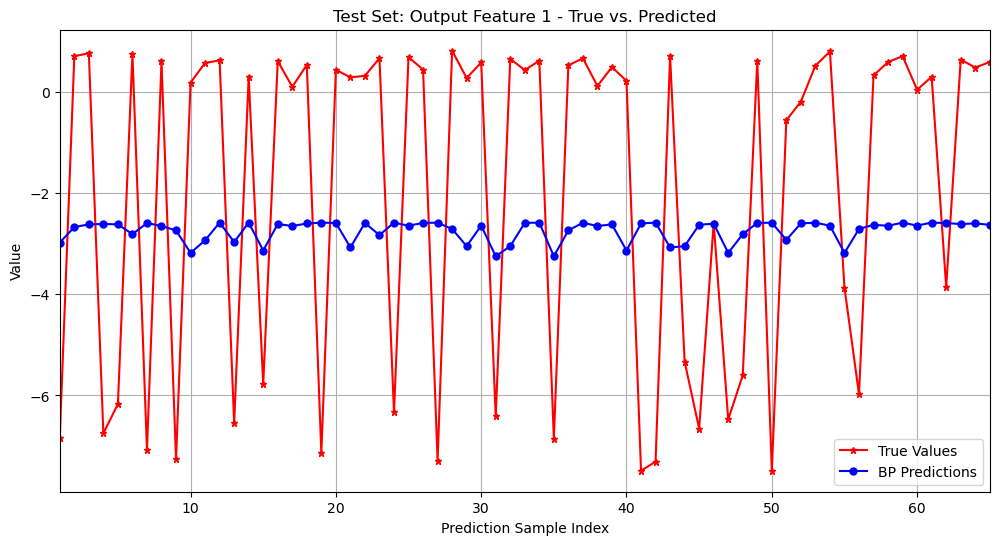

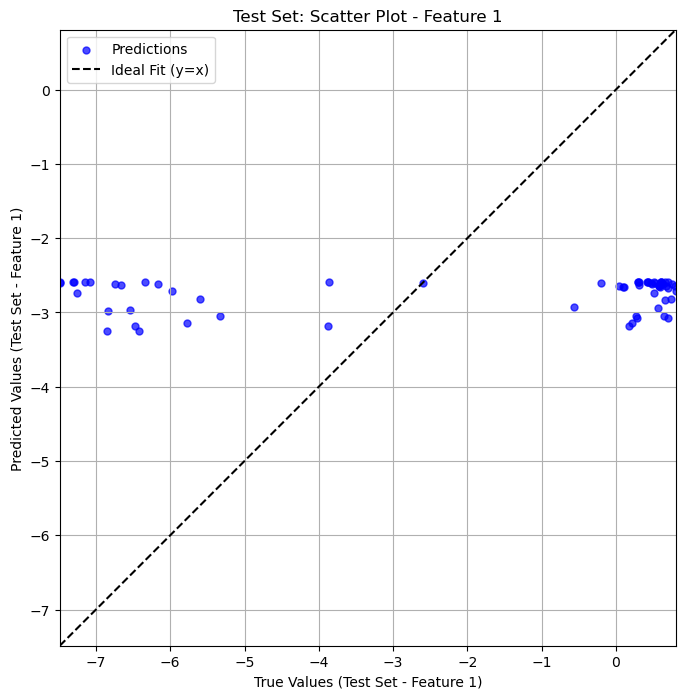

Test Set     R2: -0.0465
Test Set     MSE: 11.2938

**************************************************
           Metrics for Output Feature 2           
**************************************************


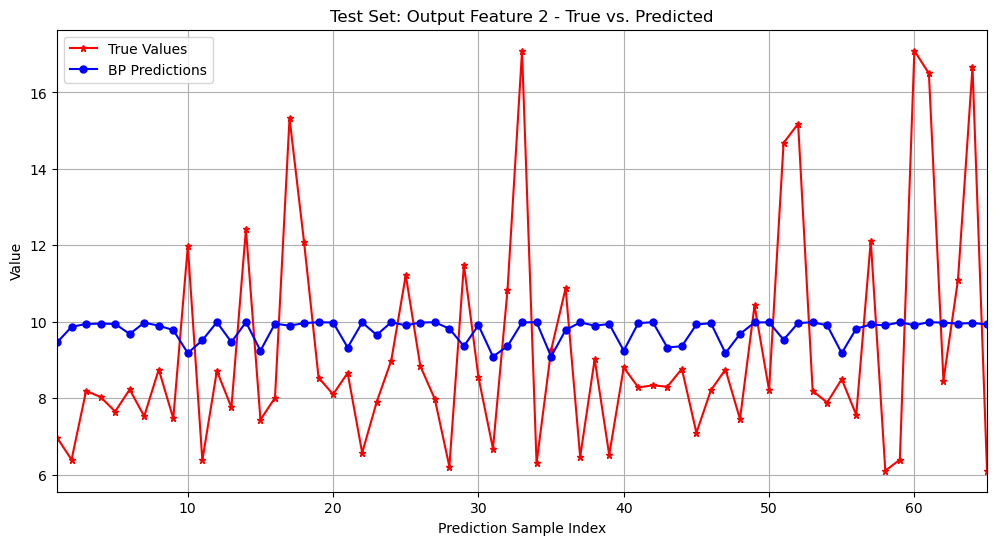

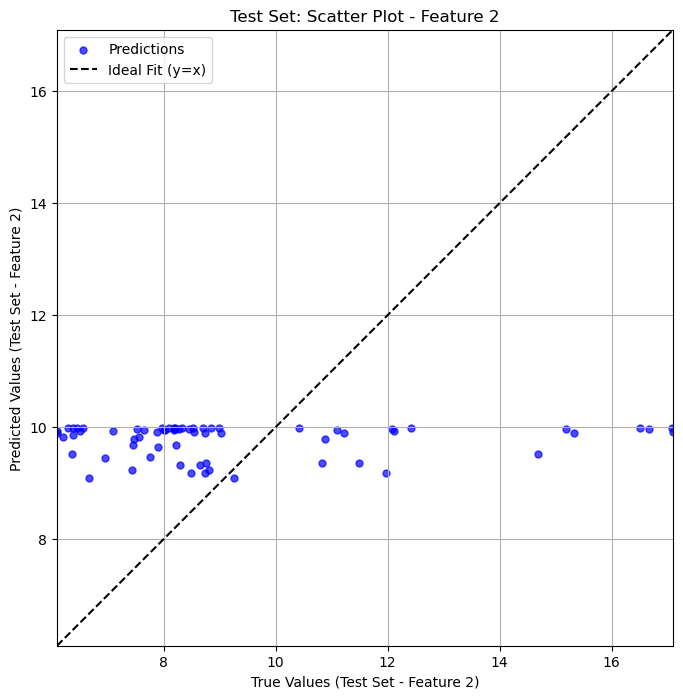

Test Set     R2: -0.0291
Test Set     MSE: 8.3592


In [335]:
for i in range(num_output_features_to_evaluate):
    print(f"\n**************************************************")
    print(f"           Metrics for Output Feature {i+1}           ")
    print(f"**************************************************")

    # Extract current feature's true values and predictions
    T_test_feat_true = scaled_y_new_val[:, i]
    T_sim2_feat_pred = y_sim2_scaled_np[:, i]

    # Test set
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(1, M_new_val + 1), T_test_feat_true, 'r-*', label='True Values', markersize=5)
    plt.plot(np.arange(1, M_new_val + 1), T_sim2_feat_pred, 'b-o', label='BP Predictions', markersize=5)
    plt.legend()
    plt.xlabel('Prediction Sample Index')
    plt.ylabel('Value')
    plt.title(f'Test Set: Output Feature {i+1} - True vs. Predicted')
    plt.xlim([1, M_new_val])
    plt.grid(True)
    plt.gcf().set_facecolor('w') # Set figure background to white
    plt.show()

    # Test set
    plt.figure(figsize=(8, 8))
    min_val_test = min(np.min(T_test_feat_true), np.min(T_sim2_feat_pred))
    max_val_test = max(np.max(T_test_feat_true), np.max(T_sim2_feat_pred))
    plt.scatter(T_test_feat_true, T_sim2_feat_pred, s=25, c='blue', alpha=0.7, label='Predictions')
    plt.plot([min_val_test, max_val_test], [min_val_test, max_val_test], '--k', label='Ideal Fit (y=x)')
    plt.xlabel(f'True Values (Test Set - Feature {i+1})')
    plt.ylabel(f'Predicted Values (Test Set - Feature {i+1})')
    plt.title(f'Test Set: Scatter Plot - Feature {i+1}')
    plt.xlim([min_val_test, max_val_test])
    plt.ylim([min_val_test, max_val_test])
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    
    # %% Other Relevant Metrics
    # R-squared (Coefficient of Determination)
    r2_test = r2_score(T_test_feat_true, T_sim2_feat_pred)
    print(f"Test Set     R2: {r2_test:.4f}")
    
    # Mean Squared Error (MSE)
    mse_test = mean_squared_error(T_test_feat_true, T_sim2_feat_pred)
    print(f"Test Set     MSE: {mse_test:.4f}")